In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Predict The Stock Market With Machine Learning And Python

Video by Vik from DQ from [here](https://www.youtube.com/watch?v=mLtMHPsfy4k). He uses backtesting and random forrest classifier. This is the first viewo I am doing for stock market instead of temprature or other things.

In [1]:
import yfinance as yf
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'yfinance'

In [23]:
if os.path.exists("sp500.csv"):
  sp500 = pd.read_csv('sp500.csv', index_col = 0)
else:
  sp500 = yf.Ticker("^GSPC") #mind the ^ This is a Ticker class
  sp500 = sp500.history(period="max") # Query historical prices
  sp500.to_csv("sp500.csv") # Each row is for a single trading DAY

# Cleaning and Visualising Data

In [24]:
sp500.index = pd.to_datetime(sp500.index) #ALWAYS make the index coloumn the datetime

In [25]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-29 00:00:00-04:00,3999.530029,4030.590088,3999.530029,4027.810059,4145250000,0.0,0.0
2023-03-30 00:00:00-04:00,4046.739990,4057.850098,4032.100098,4050.830078,3930860000,0.0,0.0
2023-03-31 00:00:00-04:00,4056.179932,4110.750000,4056.179932,4109.310059,4525120000,0.0,0.0


In [26]:
!ls -lh

total 2.6M
drwx------ 5 root root 4.0K Apr  4 13:43 drive
drwxr-xr-x 1 root root 4.0K Mar 31 13:36 sample_data
-rw-r--r-- 1 root root 2.6M Apr  4 13:48 sp500.csv


<Axes: title={'center': 'S&P 500 Closing Values History'}, xlabel='Date'>

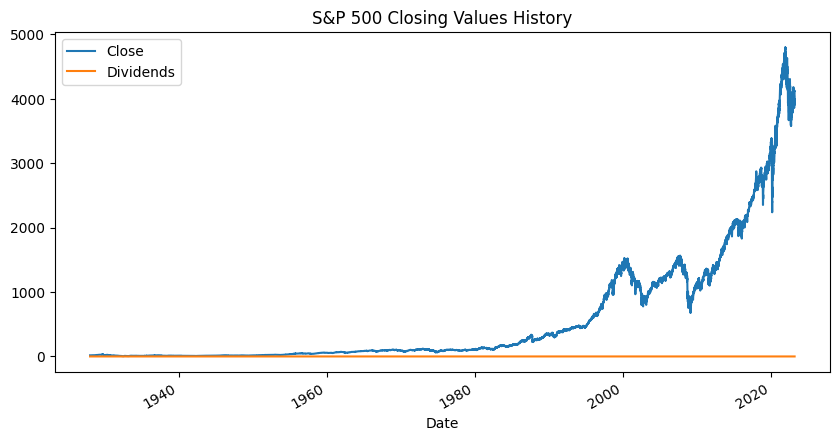

In [37]:
sp500.plot.line(y = ['Close',"Dividends"], use_index = True, figsize = (10,5), title = "S&P 500 Closing Values History")

In [38]:
del sp500['Dividends'] # no useful trends for us more appropirate for individual stocks
del sp500['Stock Splits'] # 

In [39]:
sp500['Tomorrow'] = sp500['Close'].shift(-1) # will the price go up or down tomorrow.
# It is better to be accurate on the directionality instead of absolute price value.
# You can be very accurate on the absolute price but VERY FAR on weather it is going to be going up or down 

In [41]:
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int) 
# If index goes up Traget is a 1 if comes down, or the same its 0, its boolean but we convert to integer

In [42]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [44]:
sp500 = sp500.loc['1990-01-01':].copy() # use data from 1990 and later
# if you go back too far the market would have shofted fundementally and it is 
# not a god idea to go back really far for the stock market.
# We use .copy() to avoid slicing witih copy warning

# Initial model.

RF is good, because it picks up non-linear tendency in data. They are a bit more resisitant to overfitting because they are avergaing the values over the trees.

min_sample split: protects against overfitting, controls how deep the tree can go. We do not want it too deep because it will be overfitting. 

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, min_samples_split=100, random_state = 1)

# Obvioulsy we will avoid using future data to predict the pass.

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

# Always be explicit with the FEATURES
FEATURES = ['Close','High','Low','Volume','Open']

rf.fit(train[FEATURES], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

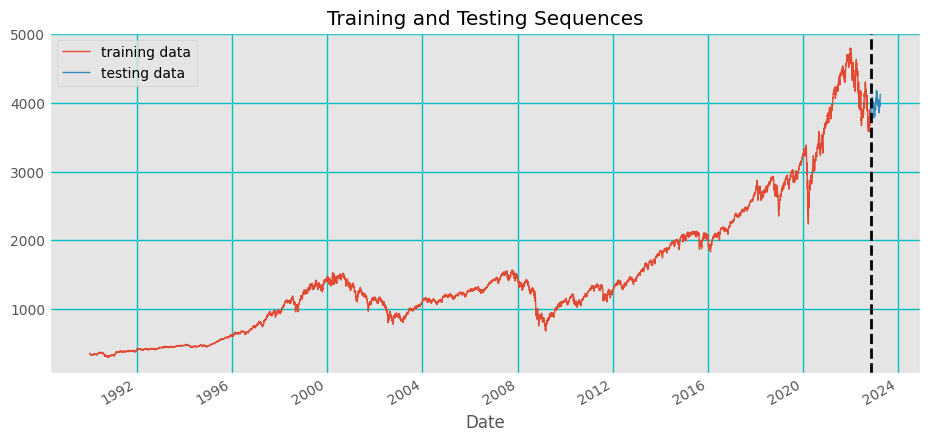

In [81]:
fig, ax = plt.subplots(figsize = (10,5))

train['Close'].plot.line(ax = ax, lw = 1, label = 'training data', title = "Training and Testing Sequences")
test['Close'].plot.line(ax = ax, label = 'testing data', lw = 1)
ax.axvline(train.index[-1], color = 'black', ls = '--', lw = 2 )
ax.grid(which='major', color='c', linestyle='-')
ax.legend()


# Measuring accuracy.
When we aid that the Target was a 1, did it actually go up? This can be adjusted. 

In [87]:
from sklearn.metrics import precision_score

preds = rf.predict(test[FEATURES])
preds = pd.Series(preds, index = test.index) # preds originally are numpy arrays.
precision_score(test["Target"], preds)

0.4090909090909091

So when we said the stock price is going to go up, it went up only 40% of the time. This is terrible.

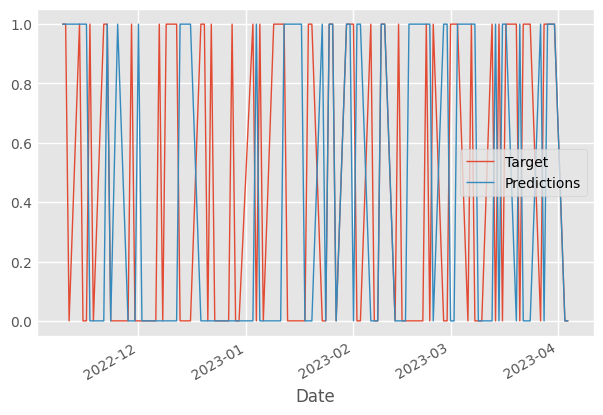

In [92]:
combined = pd.concat([test['Target'],preds], axis = 1) # combine actual vlaues with predicted values.
combined.plot(lw = 1)
plt.legend(['Target','Predictions'])

It is always usefull to have functions for predictions and backtests. Therefore:

#Backtesting 

In [93]:
def predict (train, test, FEATURES, model):
  model.fit(train[FEATURES],train["Target"])
  preds = model.predict(test[FEATURES])
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined 

In [95]:
#You could implement this one  with the built in sklarn functionaity as well. 
# Every year has 250 trading days, so we use the first 10 years of data (2500), then predict for 11th year, and then we 
# use the first 11 years to do the 12th year.

def backtest(data, model, FEATURES, start = 2500, step = 250):
  all_predictions = [] # list of dataframe year by year. 

  for i in range (start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, FEATURES, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions) # get list of dfs and get one single df

In [96]:
predictions = backtest(sp500, rf, FEATURES)

In [98]:
precision_score(predictions['Target'],predictions['Predictions'])

0.5277331189710611

In [99]:
predictions['Target'].value_counts()/predictions.shape[0] # Benchmark, sp500 went up 53% of the time 

1    0.533934
0    0.466066
Name: Target, dtype: float64

In [100]:
horizons = [2,5,60,250,1000] # for a variety of rolling averages
NEW_FEATURES = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"]/rolling_averages['Close']
  # the ratio between today's close and the averge of the last 2, 5, 60,... days


  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']
  # number of daysin the past "horizon days" that sp500 went up
  # Its just sums the target for the last X days, to see if we are going up or not.

  NEW_FEATURES += [ratio_column, trend_column]

Text(0.5, 1.0, 'New - Features Trends and Ratios')

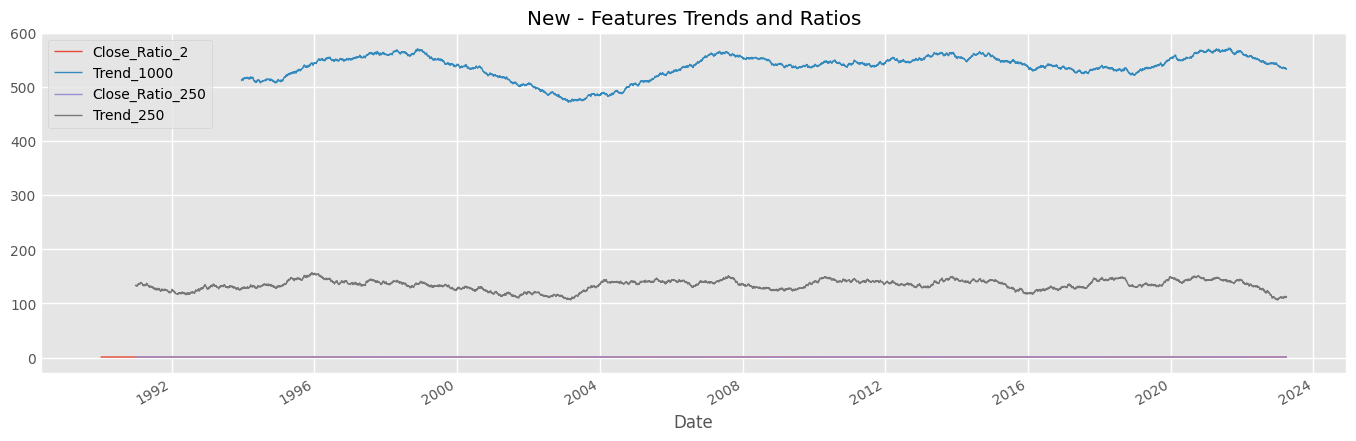

In [113]:
fig , ax = plt.subplots(figsize = (15,5))

plotting = ['Close_Ratio_2',"Trend_1000",'Close_Ratio_250',"Trend_250"]

for p in plotting:
  sp500[p].plot(ax = ax, label = p, lw = 1)

ax.legend()
ax.set_title('New - Features Trends and Ratios')

In [119]:
sp500 = sp500.dropna(subset = sp500.columns[sp500.columns != 'Tomorrow'])

In [123]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


In [121]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_split=50, random_state = 1)

# New Predict function
We want more control, so we get predict_proba method, so it gives probability that the price would go out tomorrow. 

In [129]:
def predict(train, test, FEATURES, model):
  model.fit(train[FEATURES], train['Target'])

  preds = model.predict_proba(test[FEATURES])[:,1] # second column is the probaility we want
  preds[preds >= 0.6] =1
  preds[preds<0.6] = 0
 # setting the probability threshold to 60% means that the model has to be more confident that the price will go 
 # up before it goes up. It reduces the total number of trading days, but it increases the chance of pricing go up. 
 # we do not want to trade every day, only when we are very sure 
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'],preds], axis = 1)
  return combined

In [130]:
predictions = backtest(sp500, rf, NEW_FEATURES) 

We are not using the old FUEATURES anymore, as they are all absolute values 

In [131]:
precision_score(predictions["Target"],predictions['Predictions'])

0.5694956949569495

This beats the benchmark.

In [134]:
predictions['Predictions'].value_counts() # We will be bbuying stock on far fewer days, compared to last time. 

0.0    4066
1.0     813
Name: Predictions, dtype: int64

In [132]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.543964
0    0.456036
Name: Target, dtype: float64

In [128]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,1.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,1.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2023-03-29 00:00:00-04:00,1,1.0
2023-03-30 00:00:00-04:00,1,1.0
2023-03-31 00:00:00-04:00,1,1.0


# Other things we can do

- There are exchanges that are open overnight, some indecies open before the sp500, input those prices and see if the model performs etter.

- Add in news, articles coming up, intrest rate, inflation, 

- add key stocks and key sectors, say if tech is in down turn then 6 months later sp500 will come down. 

- increase resolution, i.e. look at hourly data etc.
